## Notebook to research diabetes onset 


e) Matched Controls Diabetes Onset Curve(Blue 3)

   1. Get all the canary patients who have their CC_DIABETES flag equals 0
   on their registered date.
   
       1. Pick a matching algorithm
   2. Create the macthed population
       2. For each canary patient let their registration month be i
       2. Find N(for example 50)  control patients to match this canary patient from the pmpm 
       patients on month i who have CC_DIABETES = 0 on month i. For example the N patients should have the same age 
       and then be the nearest neighbors according to other features(log costs, cc codes etc).
       2. Set the index date for these pmpm controls patients to be month i.
       2. This forms a matched set of roughly 30 times the number of canary patients and each control has an index date.
   
   3. Compute Onset of Diabetes for month i: 
       3. Get all the matched controls with index date prior to month i.
       3. For Month i we define the total number of Diabetes Onsets(DO) as the number of subjects from e.3 that had
        the flag CC_DIABETES = 1 at Month (i) and CC_DIABETES = 0 at Month (i-1) (Note these patients must be in pmpm on both months).
       3. S is the total number of matched controls included in the pmpm both in month i and month i-1 
       3. For Month i we define the diabetes onset rate(DOR) as:
             DOR =  DO/S*1000

       3. Suggestion: Remove from  S the subjects that  have the flag CC_DIABETES = 1 at month i-1

   

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython
%reload_ext Cython

In [2]:
#built-in
import pandas as pd
import numpy as np
import time
import datetime as dt
from pathlib import Path
import time
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
import pyarrow.parquet as pq
import seaborn as sns
import sys

path = str(Path.home()) + '/rpi-canary-eval/temp'
git_path = str(Path.home()) + '/rpi-canary-eval'
sys.path.append(git_path + '/modules')


#custom
import data_process
from data_functions import make_date_to_MYR
from diabetes_onset import( process_canary,
get_tc, in_canary, diabet_onset, not_first_month_diabetes, 
                           match_data_per_month, 
                           filter_first_month_diabetes,
                           matched_population, 
                           propensity_func,
                           nearest_neighbor_func, 
                           random_matching_func, agglomerative )

from path import path_dict, col_seq_cc, col_seq_elx, col_seq_cc_all

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.random.seed(seed = 0)

/home/nneehal/.local/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Load Pmpm Canary data

In [3]:
%%time
canary_p = '../../data/CANARY/'
pmpm_p = '../../temp/CC_PMPM.p'

canary = pq.read_table(canary_p).to_pandas()
pmpm = pd.read_pickle(pmpm_p)

#drop pmpm duplicates
pmpm.drop_duplicates(subset = ['PERS_ID', 'MYR'], inplace = True)
canary.drop_duplicates(subset = ['PERS_ID'], inplace = True)

CPU times: user 5.6 s, sys: 7.25 s, total: 12.8 s
Wall time: 12.7 s


### IP-ER

In [4]:
def ip_er(group):
    x = np.arange(len(group))+1
    group['AVG_IP'] = (group.ALLOW_IP > 0).cumsum()/x
    group['AVG_ER'] = (group.ALLOW_ER > 0).cumsum()/x
    return group

def ip_er2(group, time):
    x = min(len(group), time)
    c1 = group.IP_BIN.cumsum()
    c2 = group.ER_BIN.cumsum()
    group.loc[:,'IP_BIN2'] = c1.values-c1.shift(periods = x, fill_value =0).values
    group.loc[:,'ER_BIN2'] = c2.values-c2.shift(periods = x, fill_value =0).values
    group['IP_C'] = c1
    group['ER_C'] = c2
    return group

In [5]:
%%time
pmpm = pmpm.sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
pmpm['IP_BIN'] = (pmpm.ALLOW_IP > 0).astype(int)
pmpm['ER_BIN'] = (pmpm.ALLOW_ER > 0).astype(int)

CPU times: user 7.12 s, sys: 2.66 s, total: 9.78 s
Wall time: 9.78 s


In [6]:
%%time
pmpm = pmpm.groupby('PERS_ID').apply(ip_er2, time = 6).reset_index(drop = True)

CPU times: user 32min 48s, sys: 20.2 s, total: 33min 8s
Wall time: 33min 5s


## Log the cost at source - PMPM

In [7]:
%%time
pmpm.ALLOW_AMT = pmpm.ALLOW_AMT.apply(data_process.log_)
pmpm.ALLOW_IP = pmpm.ALLOW_IP.apply(data_process.log_)
pmpm.ALLOW_ER = pmpm.ALLOW_ER.apply(data_process.log_)

CPU times: user 40.4 s, sys: 332 ms, total: 40.7 s
Wall time: 40.7 s


In [8]:
medicaid_mask = pmpm.MEDICAID_LOB.str.contains(r'.*Medicaid-.*')
pmpm['LOB'] = 1
pmpm.loc[medicaid_mask, 'LOB'] = 0
pmpm['MEDICAID_LOB'] = pmpm['LOB']
pmpm = pmpm.drop(['LOB'], axis=1)

In [9]:
pmpm = pmpm[col_seq_cc_all]

## Choose Onset Column Name

In [10]:
onset = "CC_DIABETES"

In [11]:
pmpm.head()

PERS_ID     MYR  AGE_AT_MIDMONTH MBR_GNDR  MEDICAID_LOB  ALLOW_AMT  ALLOW_ER  ALLOW_IP  CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS  CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR  CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER  CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  CC_OBESITY  \
0      -3  201908              119        M             1        0.0       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  0.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          0                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                0.0              0.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0         0.0   
1      -3  201909              119        M             1        0.0       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  0.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          0                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                0.0              0.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0         0.0   
2      -3  201910              119        M             1        0.0       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  0.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          0                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                0.0              0.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0         0.0   
3      -3  201

### Process Canary
1. Drop register dates beyond pmpm max date
2. Transform register date to MYR
3. Keep only ids and MYR

### Get Controls and Treated

In [12]:
%%time
canary2 = process_canary(canary, pmpm.MYR.max())
treated, controls = get_tc(pmpm.copy(), canary2)

CPU times: user 6.86 s, sys: 2.6 s, total: 9.47 s
Wall time: 9.46 s


### Keep Canary Patients from their date of registeration and onwards which did not have CC_DIABETES flag on, on their date of registration

In [13]:
%%time
treated2 = in_canary(treated.copy(), canary2)
treated2 = filter_first_month_diabetes(treated2.copy(), onset=onset)
treated2.drop(columns = ['IN_CANARY'], inplace = True)

CPU times: user 7.29 s, sys: 8.1 ms, total: 7.3 s
Wall time: 7.29 s


### Transform with NN

In [1]:
#!aws s3 cp s3://cdphp-s3-us-e-p-pond/rpi/nneehal/MODELS/TF_Latent_Model_m6 ../../temp/TF_Latent_Model_m6

download: s3://cdphp-s3-us-e-p-pond/rpi/nneehal/MODELS/TF_Latent_Model_m6 to ../../temp/TF_Latent_Model_m6


In [14]:
import tensorflow as tf
from tensorflow.keras import models, layers
import warnings
warnings.filterwarnings('ignore')

model = models.load_model(path+"/TF_Latent_Model_m6", compile=False)

/usr/local/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type

In [15]:
cols_to_keep = ["PERS_ID", "MYR", onset]

In [16]:
latent_cols = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16']

In [18]:
%%time
#transform data of sick and healthy treated, and controls
tr2 = data_process.transform_features_with_NN(model, treated2[col_seq_cc_all].copy(), cols_to_keep, latent_dim=16)
cntrls = data_process.transform_features_with_NN(model, controls[col_seq_cc_all].copy(), cols_to_keep, latent_dim=16)

CPU times: user 1min 42s, sys: 21.6 s, total: 2min 4s
Wall time: 1min 10s


### For each patient in the treated group in its registartion month find a population of matched controls in the same month by using 

In [19]:
%%time

columns_to_match = latent_cols 

nnr_func_args = {'match_on':columns_to_match, 'neighbors_per_treated': 5}
matched0, matched_data0 = matched_population(tr2.copy(), 
                                           cntrls.copy(),
                                           nearest_neighbor_func, 
                                           nnr_func_args)

Mathcing Function: nearest_neighbor_func
CPU times: user 41min 55s, sys: 19min 42s, total: 1h 1min 38s
Wall time: 22min 44s


In [20]:
random_matching_func_args = {'neighbors_per_treated': 100}
random_controls = matched_population(tr2.copy(), 
                                       cntrls.copy(),
                                       random_matching_func, 
                                       random_matching_func_args)

Mathcing Function: random_matching_func


In [21]:
matched_data0.to_pickle(path+'/ldata_knn/match0_l.p')
random_controls.to_pickle(path+'/ldata_knn/random_l.p')
tr2.to_pickle(path+'/ldata_knn/treated0_l.p')

## Transform Back to Original Space - match0, match1, random_controls
matched0 (latent) -> transform using controls -> matched0_orig <br/> 
matched1 (latent) -> transform using controls -> matched1_orig <br/>
random_controls (latent) -> transform using controls -> random_controls_orig <br/>
treated0(original) -> done -> tr0 (latent) <br/>
treated1(original) -> done -> tr1 (latent) <br/>

In [22]:
matched_data0 = controls[controls.set_index(["PERS_ID", "MYR"]).index.isin(matched_data0.set_index(["PERS_ID", "MYR"]).index)].sort_values(by=["PERS_ID", "MYR"])
random_controls = controls[controls.set_index(["PERS_ID", "MYR"]).index.isin(random_controls.set_index(["PERS_ID", "MYR"]).index)].sort_values(by=["PERS_ID", "MYR"])

In [23]:
matched_data0.to_pickle(path+'/odata_knn/match0_o.p')
random_controls.to_pickle(path+'/odata_knn/random_o.p')
treated2.to_pickle(path+'/odata_knn/treated0_o.p')

### Save to AWS

In [24]:
import os
l_files_list = os.listdir(git_path+"/temp/ldata_knn/")
o_files_list = os.listdir(git_path+"/temp/odata_knn/")

#save in S3
import boto3
s3 = boto3.client('s3')
bucket = 'cdphp-s3-us-e-p-pond'
for file in l_files_list:
    s3.upload_file( git_path+"/temp/ldata_knn/"+file,
                    bucket, 
                    'rpi/nneehal/DATA/ldata/m6_knn_no_cluster_only_latent/'+file,
                    ExtraArgs = {'ACL':"bucket-owner-full-control", 'ServerSideEncryption':'AES256'})
for file in o_files_list:
    s3.upload_file( git_path+"/temp/odata_knn/"+file,
                    bucket, 
                    'rpi/nneehal/DATA/odata/m6_knn_no_cluster_only_latent/'+file,
                    ExtraArgs = {'ACL':"bucket-owner-full-control", 'ServerSideEncryption':'AES256'})

### Run the Diabetes onset Function

In [25]:
%%time
con_onset0 = diabet_onset(matched_data0.copy(), 'Diabetes_Con0')

treated_onset0 = diabet_onset(treated2.copy(), 'Diabetes_Tr')

pmpm2 = filter_first_month_diabetes(pmpm.copy())
pmpm_onset = diabet_onset(pmpm2, 'Diabetes_PM')

CPU times: user 4min 51s, sys: 12 s, total: 5min 3s
Wall time: 5min 1s


In [26]:
random_onset = diabet_onset(random_controls.copy(), 'Diabetes_Rnd')

In [27]:
con_onset20 = con_onset0.rename(columns = {'Sample': 'Sample_Con0', 'Per_1000':'Per_1000_Con0'})

treated_onset20 = treated_onset0.rename(columns = {'Sample': 'Sample_Tr0', 'Per_1000':'Per_1000_Tr0'})

pmpm_onset2 = pmpm_onset.rename(columns = {'Sample': 'Sample_PM', 'Per_1000':'Per_1000_PM'})

In [28]:
random_onset2 = random_onset.rename(columns = {'Sample': 'Sample_PM', 'Per_1000':'Per_1000_PM'})
joint = pd.concat((con_onset20, treated_onset20,  pmpm_onset2, random_onset2), axis = 1)

### Diabetes Onset Per Month

1. **_Con : For Matched Controls Population**
2.  **_Tr : For Canary Treated Population**
3. **_PM : For the whole PMPM Population**
4. **_Rnd: For a Random Matching**

In [29]:
joint.describe().loc[['mean', 'std']]

Sample_Con0  Diabetes_Con0  Per_1000_Con0  Sample_Tr0  Diabetes_Tr  Per_1000_Tr0      Sample_PM  Diabetes_PM  Per_1000_PM     Sample_PM  Diabetes_Rnd  Per_1000_PM
mean  2090.547619       3.857143       1.260138  479.785714     1.000000      1.467783  143003.882353   279.901961     1.961085  32614.071429     58.095238     1.659479
std   1978.539129       4.458871       1.161658  459.026411     1.343457      2.516736   13718.389511    44.775554     0.272818  28436.331025     51.143895     0.653605

In [30]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-dark')

In [31]:
joint2 = pd.concat((con_onset0,  treated_onset0,   pmpm_onset, random_onset), axis = 1)
jointcon0 = joint2.Per_1000.iloc[1:, 0].reset_index()
jointTr0 = joint2.Per_1000.iloc[1:, 1].reset_index()
jointpmpm = joint2.Per_1000.iloc[1:, 2].reset_index()
jointrandom = joint2.Per_1000.iloc[1:, 3].reset_index()

**Plot Top Left**: $f(x)$ = Onset Per 1000 per month </br>
**Plot Top Right and Bottom Left**: $F(x) = \int_0^x f(y)dy$ Cumulative sum of the rates

No handles with labels found to put in legend.


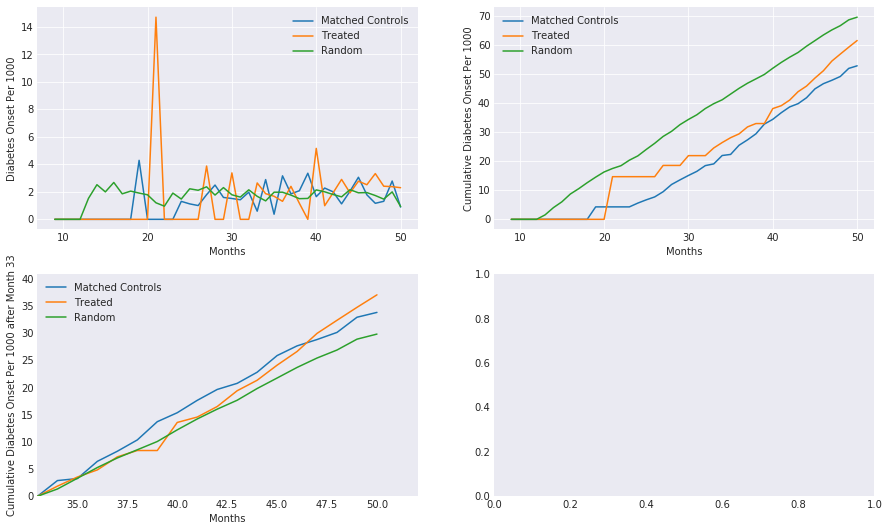

In [32]:
from diabetes_onset_plotter import plot_onset, plot_onset2
names = ['Matched Controls', 'Treated', 'Random']
f, ax = plot_onset2(jointcon0, jointTr0, jointrandom, names = names)
#f.savefig('figs/onset.png')
plt.show()

In [33]:
try:
    pmpm2.MBR_GNDR.replace(to_replace = {'F':0, 'M':1}, inplace = True)
except:
    pass

#model 4
columns_to_match = ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR', 'CC_CHRONIC_KIDNEY', 'CC_HEART_FAILURE', 'CC_ISCHEMIC', 
                    'CC_STROKE', 'CC_HYPERLIPIDEMIA', 'CC_HYPERTENSION']

tr_desc0 = treated2[columns_to_match].describe().loc[['mean', 'std']]
tr_desc0 = tr_desc0.T

con_desc0 = matched_data0[columns_to_match].describe().loc[['mean', 'std']]
con_desc0 = con_desc0.T

pmpm_desc = pmpm2[columns_to_match].describe().loc[['mean', 'std']]
pmpm_desc = pmpm_desc.T

random_desc = random_controls[columns_to_match].describe().loc[['mean', 'std']]
random_desc = random_desc.T

alli = pd.concat((tr_desc0, con_desc0, pmpm_desc, random_desc), axis = 1, keys = ['Treated',
                                                                                 'Matched Controls',
                                                                                'Genaral Population', 
                                                                                 'Random'] )

In [34]:
alli

Treated            Matched Controls            Genaral Population                Random           
                        mean        std             mean        std               mean        std       mean        std
AGE_AT_MIDMONTH    50.442683  12.451195        51.038168  12.427228          48.759167  19.438676  49.865170  19.406531
ALLOW_AMT           4.117075   2.782723         3.937520   2.841753           3.812455   2.889771   3.765967   2.890884
MBR_GNDR            0.185498   0.388710         0.321530   0.467066           0.421103   0.493736   0.420245   0.493598
CC_CHRONIC_KIDNEY   0.034313   0.182035         0.034303   0.182007           0.055803   0.229541   0.056993   0.231829
CC_HEART_FAILURE    0.024078   0.153296         0.021787   0.145987           0.033958   0.181120   0.037988   0.191168
CC_ISCHEMIC         0.079179   0.270025         0.087199   0.282128           0.102430   0.303213   0.115458   0.319574
CC_STROKE           0.007219   0.084659         0.005943   0.076860           0.010214   0.100547   0.011095   0.104746
CC_HYPERLIPIDEMIA   0.245717   0.430521         0.231738   0.421944           0.238015   0.425868   0.248193   0.431964
CC_HYPERTENSION     0.319276   0.466207         0.277802   0.447917           0.283097   0.450503   0.292760   0.455029

## Distribution of latent space

In [36]:
import pickle
with open(path+'/ldata_prop/match0_l.p', 'rb') as fp:
    controls_sick_latent = pickle.load(fp)
with open(path+'/ldata_prop/random_l.p', 'rb') as fp:
    random_latent = pickle.load(fp)
with open(path+'/ldata_prop/treated0_l.p', 'rb') as fp:
    treated_sick_latent = pickle.load(fp)

In [37]:
columns_to_match = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16']

tr_desc0 = treated_sick_latent[columns_to_match].describe().loc[['mean','std']].T
con_desc0 = controls_sick_latent[columns_to_match].describe().loc[['mean','std']].T
random_desc = random_latent[columns_to_match].describe().loc[['mean','std']].T

alli_latent = pd.concat((tr_desc0, con_desc0, random_desc), axis = 1, keys = ['Treated', 'Matched Controls', 'Random'] )

In [38]:
alli_latent

Treated           Matched Controls               Random          
          mean       std             mean       std       mean       std
x1   -1.122658  0.252410        -1.154579  0.384301  -1.096982  0.398632
x2   25.269798  5.880890        26.040136  8.879738  24.895975  9.246932
x3    8.884899  2.083620         9.168182  3.162747   8.750403  3.284964
x4   -6.297783  1.459073        -6.493834  2.211341  -6.200713  2.297925
x5    2.596100  0.628353         2.689618  0.951901   2.569811  0.984273
x6    7.563324  1.740833         7.788505  2.630635   7.445525  2.740589
x7  -12.349299  2.867573       -12.727588  4.328500 -12.173424  4.507110
x8   -4.453198  1.028863        -4.561381  1.511263  -4.367503  1.584390
x9  -27.199741  6.351096       -28.024700  9.581221 -26.791422  9.981279
x10   8.625758  2.050317         8.906438  3.111096   8.493896  3.229138
x11  18.561787  4.383169        19.152731  6.623430  18.308037  6.889866
x12  -4.497241  1.033094        -4.631039  1.573406  -4.415634  1.636646
x13 -21.719242  5.051057       -22.382231  7.620902 -21.411966  7.938431
x14 -16.710945  3.880531       -17.207375  5.835706 -16.465891  6.084957
x15 -15.005270  3.510673       -15.459655  5.301953 -14.772689  5.523532
x16   5.605534  1.299088         5.761165  1.933030   5.521250  2.020768